In this notebook we are going to implement some baseline algorithms for oferring recommendations to individual users.

As mentioned in the data document, we are going to start by implementing "basic.Popular" from the Lenskit library.

The mentioned algorithm will recommend the items, movie in this case, ordered by popularity. 

First, we will import the required libraries for Lenskit

In [281]:
import numpy as np
from lenskit import batch, crossfold
from lenskit.algorithms import Recommender, bias, basic, item_knn
from lenskit.metrics.predict import rmse, user_metric
from lenskit.algorithms import basic
from sklearn.metrics import mean_absolute_error



Now we will upload the pre-processed data from the previous notebook we created. 

In [282]:
import pandas as pd
preprocessed_dataset_folder = "../Data/PreprocessedDataset"
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
display(ratings_df.head(10))


,user,item,rating,timestamp
0,17783,5954,5.0,1288572640
1,147353,2805,2.0,979368264
2,32778,1982,4.0,1559214270
3,17160,1225,4.5,1151466878
4,58005,6537,3.0,1112739432
5,133040,736,2.0,1076959711
6,73670,4975,2.0,1415292692
7,118041,1248,4.5,1522631138
8,73268,122904,0.5,1475355740
9,133495,1388,1.0,991281570


What are the pros and cons of the first baseline, on our MovieLens dataset?

-it is a basic algorithm, easy to scale for a big dataset like ours, even if we use small samples 

-will be our first comparison point to more advanced soltuions 

-it s a non personalized algorithm so unfortunetally will not take into consideration users prefferences, but will be 

interesing to compare with peronalized baselines. 

In [283]:
popular_recommender = Recommender.adapt(basic.Popular()) 

For splitting our data into test and train sets we will use the K-fold cross validation. 

This has the advantage of evaluating the algorithm on different subsets of the data each time so we can have a better conclusion how it performs on different unseen data sets.

 Also because of this we are less prone to overfitting, tho this is a simple algorithm and this should not be a problem for this specific case. 

We experimented using different values for the number of folds and we concluded that using 3 folds will obtain the best accuracy. 

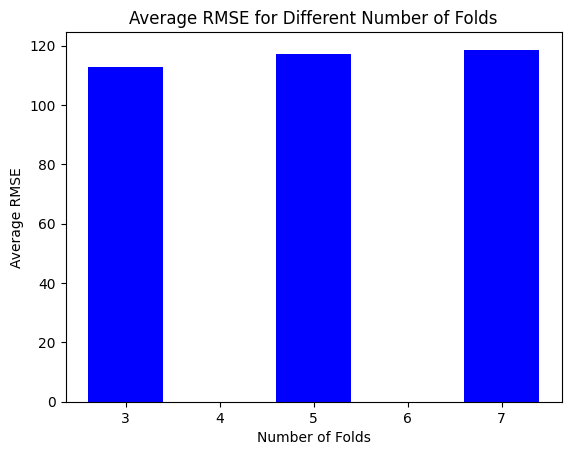

In [284]:
import matplotlib.pyplot as plt

folds = [3, 5, 7]
rmse_values = [112.84, 117.02, 118.61]

plt.bar(folds, rmse_values, color='blue')


plt.title('Average RMSE for Different Number of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Average RMSE')

plt.show()

In [285]:
splits = crossfold.partition_users(ratings_df, 3, crossfold.SampleFrac(0.2))
media_rmse = 0
media_mae = 0

Now we will train our algorithm on the k-1 folds and thest on the k last fold. 

We have to copy the original splits in order to not mpdify the data. Then we will generate the recommendations for the users from the test sets. 

We will recommend first 10 movies based on popularity (for Basic.Popular algorithm).

In [286]:



for i, (train, test) in enumerate(splits):
        #copy our splits to not modify the data
        train_ratings = train.copy()
        test_ratings = test.copy()

       #fit the popular model
        popular_recommender.fit(train_ratings)
        
        users = test_ratings['user'].unique()
        recommendations = batch.recommend(popular_recommender, users, 10)
        min_score = recommendations['score'].min()
        max_score = recommendations['score'].max()

        recommendations['score'] = 5 * (recommendations['score'] - min_score) / (max_score - min_score)
       
        #we evsaluate the recoomendations ccomparing the ratings with our predictions
        test_pred = pd.merge(test_ratings[['user', 'item', 'rating']], recommendations, on=['user', 'item'])
        test_rmse = rmse(test_pred['rating'], test_pred['score'])
        test_mae = mean_absolute_error(test_pred['rating'], test_pred['score'])
    
        media_rmse = media_rmse +test_rmse
        media_mae = media_mae + test_mae
        print(f'Split {i + 1} RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}')

        

Split 1 RMSE: 3.10, MAE: 2.84
Split 2 RMSE: 2.40, MAE: 2.15
Split 3 RMSE: 2.28, MAE: 1.91


In the end, after we calculated the RMSE for each one of the 5 folds we compute the average which we will use for further comparison. 

In [287]:
average_rmse = media_rmse / 3
print(f'Average RMSE over all splits for Popularity algo: {average_rmse:.2f}')
average_mae = media_mae / 3  
print(f'Average MAE over all splits: {average_mae:.2f}')

Average RMSE over all splits for Popularity algo: 2.59
Average MAE over all splits: 2.30


Now we will implement another baseline in order to compare with the popularity one, which did not performed that good.

 The results will be compared and disussed later. The new baseline we will implement is BiasOnly model.
 
The pros and cons for this algorithm and why we chose it are:

-as being simple algorithm, is again suitable for large and sparse datasets as our 

-in comparison with the popularity one this is personalized taking into account item and user biases



In [288]:
bias_recommender = Recommender.adapt(bias.Bias())
splits = crossfold.partition_users(ratings_df, 3, crossfold.SampleFrac(0.2))
media_rmse_2 = 0
media_mae_2 = 0

We will use the same k fold crss validation explained above with only 3 folds as provided the best results. We also need to keep the same evaluation structure for the shake of comparison. The code will remain the same, as exaplained above. 

In [289]:


for i, (train, test) in enumerate(splits):
        #copy our splits to not modify the data
        train_ratings = train.copy()
        test_ratings = test.copy()

       #fit the popular model
        bias_recommender.fit(train_ratings)
        
        users = test_ratings['user'].unique()
        recommendations = batch.recommend(popular_recommender, users, 10)
        min_score = recommendations['score'].min()
        max_score = recommendations['score'].max()


        recommendations['score'] = 5 * (recommendations['score'] - min_score) / (max_score - min_score)

        #we evsaluate the recoomendations ccomparing the ratings with our predictions
        test_pred = pd.merge(test_ratings[['user', 'item', 'rating']], recommendations, on=['user', 'item'])
        test_rmse = rmse(test_pred['rating'], test_pred['score'])

        media_rmse_2 = media_rmse_2 +test_rmse
        media_mae_2 = media_mae_2 + test_mae
        print(f'Split {i + 1} RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}')
        
average_rmse_2 = media_rmse_2 / 3
print(f'Average RMSE over all splits for Bias algo : {average_rmse_2:.2f}')
average_mae_2 = media_mae_2 / 3  # Assuming you have 3 splits
print(f'Average MAE over all splits: {average_mae:.2f}')

Split 1 RMSE: 2.13, MAE: 1.91
Split 2 RMSE: 2.11, MAE: 1.91
Split 3 RMSE: 1.79, MAE: 1.91
Average RMSE over all splits for Bias algo : 2.01
Average MAE over all splits: 2.30


Now let's combine the two created baselines and use the fallback algorithm which will take as parameters both the Popularity and Bias algorithms.

 The ideea here is that we will use our Bias algorithm first and if it fails to generate recommendations, the fallback method will then use Popularity algorithm.
 
  In such case recommendatiobs might be combined so we will expect better diversity and at the end, basicslly better results. We will see if this hypothesis holds.

The fallback method will have increased complexity but this is fine as we only work with a small sample od the data.

For the shake of comparison, the k-fold cross validation will stay the same as disucssed above. 

One advantage of adding popularity as a fallback to bias might be "the cold start problem". On the other hand, we might be more prone to overfitting so it can in some situations obtain a bigger error. 

In [290]:
#our previous baselines we will use for the fallback 
algorithms = [bias_recommender, popular_recommender] 
fallback_recommender = basic.Fallback(algorithms)

splits = crossfold.partition_users(ratings_df, 3, crossfold.SampleFrac(0.2))
media_rmse_3 = 0
media_mae_3 = 0


In [291]:
for i, (train, test) in enumerate(splits):
        #copy our splits to not modify the data
        train_ratings = train.copy()
        test_ratings = test.copy()

        #fit the popular model
        fallback_recommender.fit(train_ratings)

        users = test_ratings['user'].unique()
        recommendations = batch.recommend(popular_recommender, users, 10)
        min_score = recommendations['score'].min()
        max_score = recommendations['score'].max()

        #we had to scale the recommendation score to match with the grading criteria between 1 and 5. 
        #for examples the scores generated were between 108 and 132.
        recommendations['score'] = 5 * (recommendations['score'] - min_score) / (max_score - min_score)

        #we evsaluate the recoomendations ccomparing the ratings with our predictions
        test_pred = pd.merge(test_ratings[['user', 'item', 'rating']], recommendations, on=['user', 'item'])
        test_rmse = rmse(test_pred['rating'], test_pred['score'])

        media_rmse_3 = media_rmse_3 +test_rmse
        media_mae_3 = media_mae_3 + test_mae
        print(f'Split {i + 1} RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}')
    


average_rmse_3 = media_rmse_3 / 3
print(f'Average RMSE over all splits for Fallback algo : {average_rmse_3:.2f}')
average_mae_3 = media_mae_3 / 3  # Assuming you have 3 splits
print(f'Average MAE over all splits: {average_mae:.2f}')


Split 1 RMSE: 3.07, MAE: 1.91
Split 2 RMSE: 2.56, MAE: 1.91
Split 3 RMSE: 2.66, MAE: 1.91
Average RMSE over all splits for Fallback algo : 2.76
Average MAE over all splits: 2.30


Now let's plot the results of the two algorithms and try to compare them based on RMSE and MAE. Why do we use RMSE and MAE?

-Lenskit prvoides both of them, easy to implmenet and understand

-both evaluation methods are sensible to data sampleing, what we also did with our large dataset

-RMSE is more sensible to outliers so is not that good for very sparse samples. We show our data is not that sparse and this should not represent a big problem 


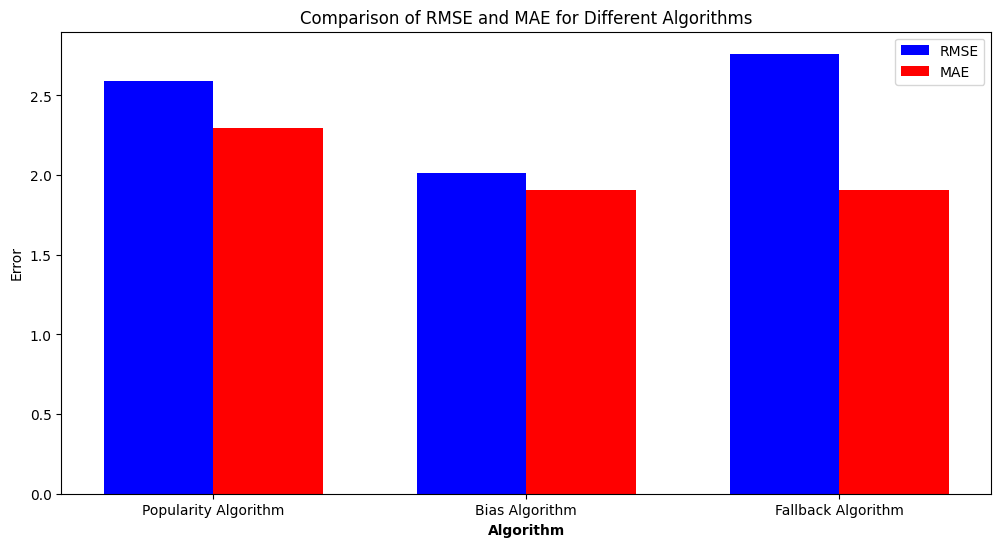

In [292]:

algorithms = ['Popularity Algorithm', 'Bias Algorithm', 'Fallback Algorithm']
rmse_values = [average_rmse, average_rmse_2, average_rmse_3]
mae_values = [average_mae, average_mae_2, average_mae_3]


bar_width = 0.35


r1 = np.arange(len(algorithms))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, rmse_values, width=bar_width, color='b', label='RMSE')
plt.bar(r2, mae_values, width=bar_width, color='r', label='MAE')

plt.xlabel('Algorithm', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(algorithms))], algorithms)
plt.ylabel('Error')
plt.title('Comparison of RMSE and MAE for Different Algorithms')
plt.legend()

plt.show()
